## Импортируем библиотеки

In [1]:
%%capture captured_output
! pip install wandb

In [43]:
import os
import re
import string
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import time
import torch
import tarfile
import concurrent.futures
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import nltk
from bs4 import BeautifulSoup
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import STOPWORDS
from google.colab import drive
from nltk import pos_tag
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from tqdm.auto import tqdm
from transformers import pipeline
from wordcloud import WordCloud
import gensim.downloader as api
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from string import punctuation
from nltk.tokenize import word_tokenize
from collections import defaultdict
import wandb
from gensim.corpora.dictionary import Dictionary
import joblib

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [4]:
file_path = '/content/drive/MyDrive/Тестовые/Тестовое_Гринатом/aclImdb_v1.tar.gz'
extract_dir = '/content/aclImdb_extracted/'
save_path = '/content/drive/MyDrive/Тестовые/Тестовое_Гринатом/'

## Распаковка архива и создание DataFrame для train и test с текстами и метками

In [ ]:
def extract_archive(archive_path, extract_path):
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)

In [ ]:
# ! rm /content/aclImdb_extracted -r

In [ ]:
extract_archive(file_path, extract_dir)

In [ ]:
# def create_dataframe(directory):
#     data = []
#     for folder in ['pos', 'neg']:
#         folder_path = os.path.join(directory, folder)
#         for file in tqdm(os.listdir(folder_path), desc=f'Обработка папки {folder}'):
#             if file.endswith('.txt'):
#                 file_path = os.path.join(folder_path, file)
#                 with open(file_path, 'r', encoding='utf-8') as f:
#                     review_text = f.read()
#                 label = 1 if folder == 'pos' else 0
#                 data.append([review_text, label])
#     df = pd.DataFrame(data, columns=['text', 'label'])

#     return df

def create_dataframe(directory):
    data = []
    for folder in ['pos', 'neg']:
        folder_path = os.path.join(directory, folder)
        for file in tqdm(os.listdir(folder_path), desc=f'Обработка папки {folder}'):
            if file.endswith('.txt'):
                file_path = os.path.join(folder_path, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    review_text = f.read()
                label = int(file.split('_')[1].split('.')[0])
                data.append([review_text, label])
    df = pd.DataFrame(data, columns=['text', 'label'])

    return df

def create_unsup_dataframe(directory):
    data = []
    unsup_dir = os.path.join(directory, 'unsup')
    for file in tqdm(os.listdir(unsup_dir), desc='Обработка папки unsup'):
        if file.endswith('.txt'):
            file_path = os.path.join(unsup_dir, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                review_text = f.read()
            data.append([review_text])
    df = pd.DataFrame(data, columns=['text'])

    return df

In [ ]:
train_dir = os.path.join(extract_dir, 'aclImdb', 'train')
test_dir = os.path.join(extract_dir, 'aclImdb', 'test')

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)
unsup_df = create_unsup_dataframe(train_dir)

Обработка папки pos:   0%|          | 0/12500 [00:00<?, ?it/s]

Обработка папки neg:   0%|          | 0/12500 [00:00<?, ?it/s]

Обработка папки pos:   0%|          | 0/12500 [00:00<?, ?it/s]

Обработка папки neg:   0%|          | 0/12500 [00:00<?, ?it/s]

Обработка папки unsup:   0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
train_df.to_csv(save_path + 'train_data.csv', index=False)
test_df.to_csv(save_path + 'test_data.csv', index=False)
unsup_df.to_csv(save_path + 'unsup_data.csv', index=False)

## Загрузка файлов csv

In [5]:
train_df = pd.read_csv(save_path + 'train_data.csv')
test_df = pd.read_csv(save_path + 'test_data.csv')
unsup_df = pd.read_csv(save_path + 'unsup_data.csv')

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
unsup_df = unsup_df.sample(frac=1, random_state=42).reset_index(drop=True)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Тестовые/Тестовое_Гринатом/train_data.csv'

## Анализ и предобработка данных

In [ ]:
train_df.shape, test_df.shape, unsup_df.shape

((25000, 2), (25000, 2), (50000, 1))

In [ ]:
train_df

,text,label
0,** WARNING - CONTAINS SPOILERS! **<br /><br />...,8
1,I'm basing this on my observations of one epis...,3
2,"Sharp, well-made documentary focusing on Mardi...",9
3,Cheezy action movie starring Dolph Lungren. Lu...,2
4,Marie Dressler carries this Depression-era dra...,4


In [ ]:
test_df.head()

,text,label
0,I swear if I did ever tried cocaine I'd be abl...,8
1,I've read all the Dave Robicheaux novels and c...,4
2,The main attraction of Anywhere but Here is th...,7
3,"In a sense, this movie did not even compare to...",4
4,I found this to be a tremendously disappointin...,4


In [ ]:
print(f'Пропущенных значений: \n{train_df.isnull().sum()}')

Пропущенных значений: 
text     0
label    0
dtype: int64


In [ ]:
duplicate_rows = train_df[train_df.duplicated()]
print(f"Количество дубликатов в данных: {duplicate_rows.shape[0]}")

Количество дубликатов в данных: 95


In [ ]:
train_df = train_df.drop_duplicates()

In [ ]:
labels_train_df = train_df['label']
len(labels_train_df)

24905

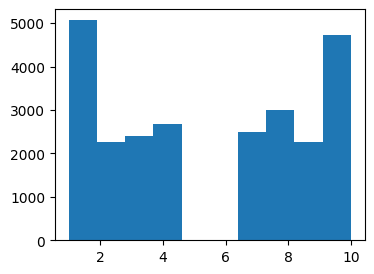

In [ ]:
# Посмотрим на распределение классов
plt.figure(figsize=(4, 3))
plt.hist(labels_train_df);

In [ ]:
# Облако слов
def create_cloud_graph(corpus):
    wordcloud = WordCloud(
        width=1600, height=800, max_words=200, background_color='white', collocations=False
    ).generate(' '.join(corpus))
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

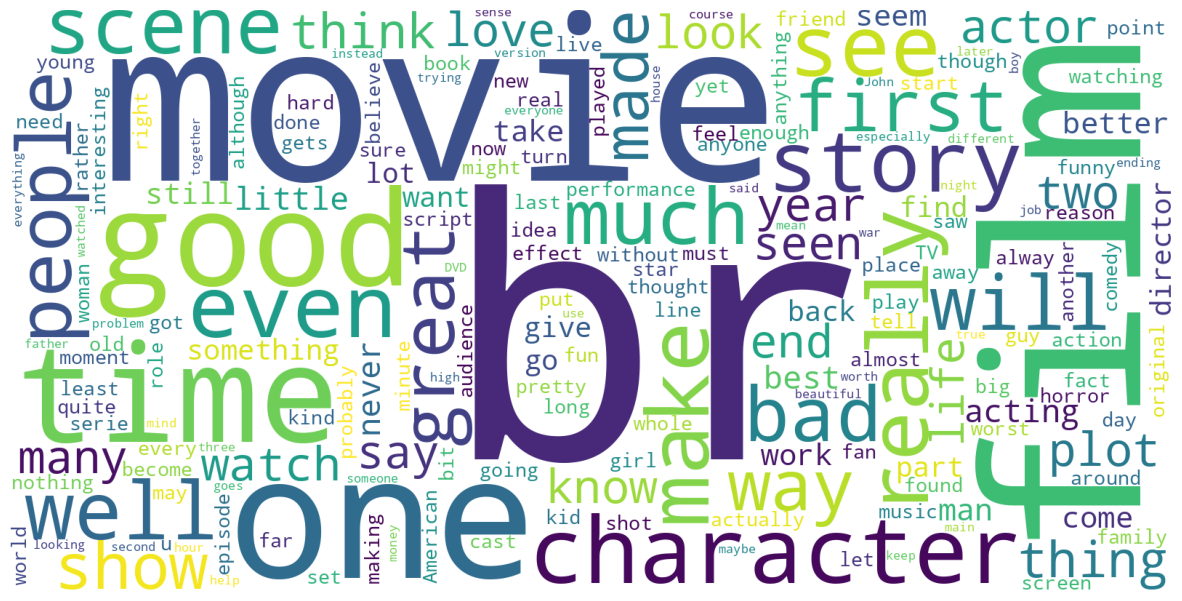

In [ ]:
create_cloud_graph(train_df['text'])

In [ ]:
texts_train_df = train_df['text'].tolist()

In [ ]:
texts_train_df[0]

"** WARNING - CONTAINS SPOILERS! **<br /><br />First of all, I would like to say that I really liked this game. I got it for Christmas after two months of dropping hints to my parents. I am glad that I did that.<br /><br />First off, I would like to say that the single player was very good. The first level is probably one of the best in the game, when you are at a party in London, and some evil guys ruin it by kidnapping the Prime minister's daughter. Of course you have to rescue her, and it is quite a big level, but should probably take you at least five minutes. The best part, and I think also the funniest part, is when you are in the jet-pack, and people are rappelling down Big Ben. Just equip the jet-pack's most trusty rocket launcher and blast the clock faces and the enemies down. Pure fun!<br /><br />The rest of the levels are very good, but pretty short. There are four mini-levels you can unlock, and that is one of the let downs, because only the first two of them are actually f

In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()
stop_words = STOPWORDS | set(nltk_stopwords.words('english'))
negation_words = {"not", "no", "never", "neither", "nor", "but", "however", "although"}
for word in negation_words:
    if word in stop_words:
        print(f'"{word}" является стоп-словом.')
    else:
        print(f'"{word}" НЕ является стоп-словом.')

"neither" является стоп-словом.
"but" является стоп-словом.
"no" является стоп-словом.
"however" является стоп-словом.
"never" является стоп-словом.
"although" является стоп-словом.
"nor" является стоп-словом.
"not" является стоп-словом.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
stop_words = stop_words - negation_words

In [ ]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
contractions_df = pd.read_csv('/content/drive/MyDrive/Тестовые/Тестовое_Гринатом/contractions.csv')
contractions = dict(zip(contractions_df['Contraction'], contractions_df['Meaning']))

In [ ]:
contractions_df.head()

,Contraction,Meaning
0,'aight,alright
1,ain't,is not
2,amn't,am not
3,aren't,are not
4,can't,cannot


In [ ]:
def expand_contractions(text):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in contractions.keys()) + r')\b')
    return pattern.sub(lambda x: contractions[x.group()], text)

def process_text(text):
    text = expand_contractions(text)
    if "<" in text and ">" in text:
        text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'\d+', '', text)
    text_without_punc = re.sub(f'[{re.escape(punctuation)}]', '', text)
    tokens = word_tokenize(text_without_punc.lower())
    pos_tags = pos_tag(tokens)
    clean_tokens = [
        lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos) or wordnet.NOUN)
        for word, pos in pos_tags
        if word not in stop_words
    ]
    return clean_tokens

def clean_texts(texts):
    clean_texts = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        results = list(tqdm(executor.map(process_text, texts), total=len(texts)))
    return results

def remove_rare_words(texts, rare_words=None):
    clean_texts = []
    if rare_words is None:
        counter_words = defaultdict(int)
        for words in texts:
            unique_words = set(words)
            for word in unique_words:
                counter_words[word] += 1
        rare_words = {word for word, counter in counter_words.items() if counter < 5}

    for words in texts:
        clean_texts.append([word for word in words if word not in rare_words])

    return clean_texts, rare_words

def process_and_remove_rare(texts, rare_words=None):
    processed_texts = clean_texts(texts)
    processed_texts, rare_words = remove_rare_words(processed_texts, rare_words)
    return processed_texts, rare_words

In [ ]:
clean_texts_train_df = clean_texts(texts_train_df)
clean_texts_train_df = remove_rare_words(clean_texts_train_df)

  0%|          | 0/24905 [00:00<?, ?it/s]

In [ ]:
clean_texts_train_df[0]

['warn',
 'contains',
 'spoiler',
 'like',
 'like',
 'game',
 'get',
 'christmas',
 'month',
 'drop',
 'hint',
 'parent',
 'glad',
 'like',
 'single',
 'player',
 'good',
 'level',
 'probably',
 'best',
 'game',
 'party',
 'london',
 'evil',
 'guy',
 'ruin',
 'kidnap',
 'prime',
 'ministeris',
 'daughter',
 'course',
 'rescue',
 'big',
 'level',
 'but',
 'probably',
 'minute',
 'best',
 'think',
 'funny',
 'people',
 'big',
 'ben',
 'equip',
 'trusty',
 'rocket',
 'launcher',
 'blast',
 'clock',
 'face',
 'enemy',
 'pure',
 'funthe',
 'rest',
 'level',
 'good',
 'but',
 'pretty',
 'short',
 'unlock',
 'let',
 'down',
 'actually',
 'fun',
 'unlock',
 'kill',
 'enemy',
 'mean',
 'cmon',
 'get',
 'load',
 'point',
 'unlock',
 'mission',
 'bonus',
 'mission',
 'badthe',
 'multi',
 'player',
 'friend',
 'agree',
 'good',
 'challenge',
 'no',
 'bot',
 'halo',
 'not',
 'bot',
 'but',
 'fine',
 'multi',
 'player',
 'game',
 'load',
 'bad',
 'guy',
 'set',
 'trap',
 'best',
 'way',
 'kill',
 'p

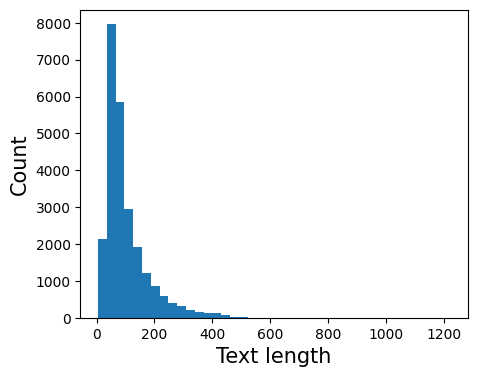

In [ ]:
# Оценим длины текстов
text_lens = [len(x) for x in clean_texts_train_df]

plt.figure(figsize=(5, 4))
plt.hist(text_lens, bins=40);
plt.xlabel('Text length', size=15)
plt.ylabel('Count', size=15);

In [ ]:
# Число уникальных слов в корпусе
def vocab_size(texts):
    vocab = set()
    for text in texts:
        if isinstance(text, list):
            vocab |= set(text)
        else:
            vocab |= set(text.split())

    return len(vocab)

In [ ]:
vocab_size(clean_texts_train_df)

23729

In [ ]:
print(f"Размер обучающей выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")

Размер обучающей выборки: (24905, 2)
Размер тестовой выборки: (25000, 2)


In [ ]:
# Предобработаем данные
texts_train = train_df['text'].tolist()
texts_test = test_df['text'].tolist()
labels_train = train_df['label']
labels_test = test_df['label']
unsup_data = unsup_df['text'].tolist()

clean_texts_train, rare_words = process_and_remove_rare(texts_train)
clean_texts_test, _ = process_and_remove_rare(texts_test, rare_words)
clean_texts_unsup, _ = process_and_remove_rare(unsup_data, rare_words)

  0%|          | 0/24905 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
vocab_size(clean_texts_train)

23729

In [ ]:
clean_texts_train_str = [' '.join(tokens) for tokens in clean_texts_train]
clean_texts_test_str = [' '.join(tokens) for tokens in clean_texts_test]
unsup_data_upset_str = [' '.join(tokens) for tokens in clean_texts_unsup]

train_clean_df = pd.DataFrame({'text': clean_texts_train_str, 'label': labels_train})
test_clean_df = pd.DataFrame({'text': clean_texts_test_str, 'label': labels_test})
unsup_clean_df = pd.DataFrame({'text': unsup_data_upset_str})

train_clean_df.to_csv(save_path + 'clean_train_data.csv', index=False)
test_clean_df.to_csv(save_path + 'clean_test_data.csv', index=False)
unsup_clean_df.to_csv(save_path + 'clean_upset_data.csv', index=False)

## Загрузка обработанных данных с диска

In [6]:
clean_train_df = pd.read_csv(save_path + 'clean_train_data.csv')
clean_test_df = pd.read_csv(save_path + 'clean_test_data.csv')
clean_unsup_df = pd.read_csv(save_path + 'clean_upset_data.csv')

clean_texts_train = [text.split() for text in clean_train_df['text']]
clean_texts_test = [text.split() for text in clean_test_df['text']]
labels_train = clean_train_df['label']
labels_test = clean_test_df['label']
clean_texts_unsup = [text.split() for text in clean_unsup_df['text']]

## Модель

### Разработка

In [40]:
# Для веторизации текста
def vectorize_texts(texts, w2v_model, desc="Vectorizing"):
    text_embeddings = []
    for words in texts:
        embeddings = np.array([w2v_model.get_vector(word) for word in words if word in w2v_model])
        if embeddings.size == 0:
            text_embeddings.append(np.zeros(w2v_model.vector_size))
        else:
            text_embeddings.append(np.mean(embeddings, axis=0))

    return text_embeddings

def train_word2vec(texts):
    return Word2Vec(texts, vector_size=100, window=5, min_count=4)

# Оценка модели
def evaluate_model(train_vec, test_vec, model, vectorizer_name, model_name):
    model.fit(train_vec, labels_train)
    predictions = model.predict(test_vec)

    accuracy = accuracy_score(labels_test, predictions)
    f1_macro = f1_score(labels_test, predictions, average='macro')
    f1_weighted = f1_score(labels_test, predictions, average='weighted')

    print(f'Accuracy_score: {accuracy:.4f} ({vectorizer_name} + {model_name})')
    print(f'F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}\n')

In [41]:
# glove_model = api.load('glove-twitter-200') (грузить долго)

# Обучение и Векторизация с CountVectorizer и TfidfVectorizer
count_vect = CountVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    min_df=5,
    max_df=0.9,
    ngram_range=(1,2)
)
train_counts = count_vect.fit_transform(clean_texts_train)
test_counts = count_vect.transform(clean_texts_test)

tfidf_vect = TfidfVectorizer(
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        min_df=5,
        max_df=0.9,
        ngram_range=(1,2)
)
train_tfidf = tfidf_vect.fit_transform(clean_texts_train)
test_tfidf = tfidf_vect.transform(clean_texts_test)

# Обучение Word2Vec и векторизация текстов
word2vec_model = train_word2vec(clean_texts_train)
train_w2v = vectorize_texts(clean_texts_train, word2vec_model.wv, desc="Vectorizing Word2Vec")
test_w2v = vectorize_texts(clean_texts_test, word2vec_model.wv, desc="Vectorizing Word2Vec")

# Векторизация с GloVe
# train_glove = vectorize_texts(clean_texts_train, glove_model, desc="Vectorizing Glove")
# test_glove = vectorize_texts(clean_texts_test, glove_model, desc="Vectorizing Glove")


# Модели классификации
classifiers = {
    # "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=10000),
    "LinearSVC": LinearSVC(max_iter=10000),
    # "RandomForestClassifier": RandomForestClassifier(class_weight='balanced'),
    # "GradientBoostingClassifier": GradientBoostingClassifier(),
    # "XGBoost": XGBClassifier(eval_metric='mlogloss')
    # "KNeighborsClassifier": KNeighborsClassifier(),
    # "SVC": SVC()
}

# Векторизаторы
vectorizers = {
    "CountVectorizer": (train_counts, test_counts),
    "TfidfVectorizer": (train_tfidf, test_tfidf),
    "Word2Vec": (train_w2v, test_w2v),
    # "GloVe": (train_glove, test_glove)
}

In [42]:
for vec_name, (train_vec, test_vec) in tqdm(vectorizers.items(), desc="Векторизаторы", total=len(vectorizers)):
    for clf_name, clf in tqdm(classifiers.items(), desc=f"Классификаторы для {vec_name}", leave=False):
        evaluate_model(train_vec, test_vec, clf, vec_name, clf_name)

Векторизаторы:   0%|          | 0/3 [00:00<?, ?it/s]

Классификаторы для CountVectorizer:   0%|          | 0/2 [00:00<?, ?it/s]

Accuracy_score: 0.3820 (CountVectorizer + LogisticRegression)
F1 Macro: 0.3100, F1 Weighted: 0.3656

Accuracy_score: 0.3518 (CountVectorizer + LinearSVC)
F1 Macro: 0.2873, F1 Weighted: 0.3408



Классификаторы для TfidfVectorizer:   0%|          | 0/2 [00:00<?, ?it/s]

Accuracy_score: 0.4224 (TfidfVectorizer + LogisticRegression)
F1 Macro: 0.2871, F1 Weighted: 0.3547

Accuracy_score: 0.3904 (TfidfVectorizer + LinearSVC)
F1 Macro: 0.3012, F1 Weighted: 0.3614



Классификаторы для Word2Vec:   0%|          | 0/2 [00:00<?, ?it/s]

Accuracy_score: 0.3979 (Word2Vec + LogisticRegression)
F1 Macro: 0.2602, F1 Weighted: 0.3282

Accuracy_score: 0.3932 (Word2Vec + LinearSVC)
F1 Macro: 0.2285, F1 Weighted: 0.2998



In [45]:
def identity_tokenizer(text):
    return text

def identity_preprocessor(text):
    return text

tfidf_vect = TfidfVectorizer(
    tokenizer=identity_tokenizer,
    preprocessor=identity_preprocessor,
    token_pattern=None,
    min_df=5,
    max_df=0.9,
    ngram_range=(1,2)
)

train_tfidf = tfidf_vect.fit_transform(clean_texts_train)
test_tfidf = tfidf_vect.transform(clean_texts_test)

classifiers = {
    "LinearSVC": LinearSVC(max_iter=10000)
}

evaluate_model(train_tfidf, test_tfidf, classifiers['LinearSVC'], 'TfidfVectorizer', 'LinearSVC')

Accuracy_score: 0.3904 (TfidfVectorizer + LinearSVC)
F1 Macro: 0.3012, F1 Weighted: 0.3614



In [46]:
joblib.dump(tfidf_vect, 'tfidf_vectorizer.pkl')

joblib.dump(classifiers["LinearSVC"], 'sentiment_model.pkl')

['sentiment_model.pkl']

In [ ]:
# pipe = Pipeline([
#     ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
#     ('clf', LogisticRegression(max_iter=10000, class_weight='balanced'))
# ])
# param_grid = {
#     'tfidf__min_df': [5, 10],
#     'tfidf__max_df': [0.7, 0.9],
#     'tfidf__ngram_range': [(1, 1), (1, 2),],
#     # 'clf__C': [0.01, 0.1, 1],
#     # 'clf__penalty': ['l2'],
#     # 'clf__solver': ['lbfgs', 'saga'],
# }
# grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='f1_weighted', verbose=1, n_jobs=-1)
# grid_search.fit(clean_texts_train, labels_train)
# print("Лучшие параметры для TfidfVectorizer и LogisticRegression:", grid_search.best_params_)
# best_f1_score = grid_search.best_score_
# print(f"Лучший F1 (Weighted) Score: {best_f1_score:.4f}")

## Word2Vec + TextCNN

In [7]:
w2v_model = Word2Vec(clean_texts_train, vector_size=100, min_count=4, window=5).wv

In [8]:
def encode_dataset(dataset):
    encoded = []
    for words in dataset:
        vectors = [w2v_model.get_vector(word) for word in words if word in w2v_model]
        encoded.append(torch.from_numpy(np.array(vectors)))

    return encoded

In [9]:
train_embeddings = encode_dataset(clean_texts_train)
test_embeddings = encode_dataset(clean_texts_test)

In [10]:
label_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 7: 4, 8: 5, 9: 6, 10: 7}
labels_train = labels_train.map(label_mapping)
labels_test = labels_test.map(label_mapping)

In [11]:
# Созданием датасета из эмбеддингов
train_dataset = list(zip(train_embeddings, labels_train))
test_dataset = list(zip(test_embeddings, labels_test))

In [12]:
def collate_fn(batch):
    x, labels = zip(*batch)
    return pad_sequence(x).permute(1, 0, 2), torch.tensor(labels)

In [13]:
from torch.utils.data import DataLoader

w2v_train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=32)
w2v_test_loader = DataLoader(test_dataset, collate_fn=collate_fn, shuffle=False, batch_size=8)

In [14]:
batch = next(iter(w2v_test_loader))

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
class TextCNN(nn.Module):
    def __init__(self, hid_dim=100, kernel_sizes=[3, 4, 5], n_classes=8):
        super().__init__()

        self.conv = nn.ModuleList([
            nn.Conv1d(in_channels=hid_dim, out_channels=hid_dim, kernel_size=k) for k in kernel_sizes
        ])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(len(kernel_sizes) * hid_dim, n_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = [self.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(self.dropout(x))

        return x

In [17]:
def compute_f1(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0.0)

    return f1


def train(model, dataloader, optimizer, device='cpu'):
    model.train()
    criterion = nn.CrossEntropyLoss()

    for i, (input_ids, labels) in enumerate(dataloader):
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        logits = model(input_ids)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = logits.argmax(dim=-1)
        f1 = compute_f1(labels, predictions)

        if i % 10 == 0:
            wandb.log({
                "train_loss": loss.item(),
                "train_f1_weighted": f1
            })


@torch.inference_mode()
def evaluate(model, dataloader, device='cpu'):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    losses = []
    all_predictions = []
    all_labels = []

    for input_ids, labels in dataloader:
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        predictions = logits.argmax(dim=-1)
        all_predictions.extend(predictions.cpu())
        all_labels.extend(labels.cpu())

    all_predictions = torch.stack(all_predictions)
    all_labels = torch.stack(all_labels)

    mean_loss = np.mean(losses)
    f1 = compute_f1(all_labels, all_predictions)

    wandb.log({
        "test_loss": mean_loss,
        "test_f1_weighted": f1
    })

    return f1, mean_loss

In [18]:
print(labels_train.unique())
print(labels_test.unique())

[5 2 6 1 3 7 4 0]
[5 3 4 6 2 7 0 1]


In [19]:
model = TextCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [20]:
wandb.init(project="Grinatom_test", name="Word2Vec + TextCNN")

wandb: Currently logged in as: evseykirichkov (evseyv). Use `wandb login --relogin` to force relogin


In [21]:
for epoch in range(15):
    train(model, w2v_train_loader, optimizer, device=device)
    test_accuracy, test_loss = evaluate(model, w2v_test_loader, device=device)

wandb.finish()

test_f1_weighted,▁▄▃▅▆▆▇▇█▆██▇██
test_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
train_f1_weighted,▁▂▁▄▅▂▄▅▃▄▄▃▂▆▅▆▄▅▅▅██▄▆▅▆▆█▃▆▅▅▅▇▆▅▆▅▅▅
train_loss,▇▄▆▅▆▄▆▇▅▆▅▅▄▁▆▄█▇▇▆▄▃▅▅▆▅▅▄▃▁▄▄▂▄▃▃▁▅▄▇
test_f1_weighted,0.35734
test_loss,1.53666
train_f1_weighted,0.61458
train_loss,1.08081


## Обучаемые эмбеддинги + TextCNN

In [22]:
dictionary = Dictionary(clean_texts_train)
dictionary.add_documents([['PAD', 'UNK']])
len(dictionary)

23731

In [23]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    pad_token_id = dictionary.token2id['PAD']
    unk_token_id = dictionary.token2id['UNK']
    input_ids = [torch.tensor(dictionary.doc2idx(text, unknown_word_index=unk_token_id)) for text in texts]
    return (
        pad_sequence(input_ids, padding_value=pad_token_id, batch_first=True).long(),
        torch.tensor(labels).long()
    )

In [24]:
train_dataset = list(zip(clean_texts_train, labels_train))
test_dataset = list(zip(clean_texts_test, labels_test))

In [25]:
ids_train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=32)
ids_test_loader = DataLoader(test_dataset, collate_fn=collate_fn, shuffle=False, batch_size=8)

In [26]:
batch = next(iter(ids_train_loader))

In [27]:
batch

(tensor([[  169,   969,  1923,  ..., 23729, 23729, 23729],
         [ 1565,  3497,  2769,  ..., 23729, 23729, 23729],
         [   63,    51,   289,  ..., 23729, 23729, 23729],
         ...,
         [  789,    98,    39,  ..., 23729, 23729, 23729],
         [ 6802,  5209,   856,  ..., 23729, 23729, 23729],
         [  331, 14593,  2205,  ..., 23729, 23729, 23729]]),
 tensor([4, 2, 0, 7, 0, 7, 1, 0, 0, 0, 6, 2, 6, 3, 0, 1, 5, 4, 1, 5, 3, 1, 7, 1,
         5, 7, 2, 3, 7, 0, 4, 6]))

In [28]:
class EmbeddingTextCNN(TextCNN):
    def __init__(self, vocab_size, hid_dim=200, kernel_sizes=[3, 4, 5], n_classes=8):
        super().__init__(hid_dim, kernel_sizes, n_classes)

        self.embedding = nn.Embedding(vocab_size, hid_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = super().forward(x)
        return x

In [29]:
model = EmbeddingTextCNN(vocab_size=len(dictionary)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-3)

In [30]:
wandb.init(project="Grinatom_test", name="TextCNN_train_embeddings")

In [31]:
for epoch in range(20):
    train(model, ids_train_loader, optimizer, device=device)
    test_accuracy, test_loss = evaluate(model, ids_test_loader, device=device)
wandb.finish()

test_f1_weighted,▁▃▄▅▇▇▇▇▇▆▇█▆▆▇▇▇▇█▇
test_loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
train_f1_weighted,▂▂▁▂▃▄▆▅▅▆▆▇▃▇▇▆▆▇▇▇▆▆▅▆▇▇██▆▇▇▄▆▆▇▅▆█▅▅
train_loss,▇▇▇█▆█▆▅▅▄▄▄▅▄▃▂▂▂▁▁▂▃▁▃▃▄▂▃▃▂▃▄▂▂▃▁▂▃▃▁
test_f1_weighted,0.34646
test_loss,1.51752
train_f1_weighted,0.68236
train_loss,1.04641


## RNN

In [32]:
class TorchRNN(nn.Module):
    def __init__(self, vocab_size, input_size=128, hidden_size=128,
                 num_layers=1, bidirectional=False, n_classes=8):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, input_size)
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            bidirectional=bidirectional,
            num_layers=num_layers,
            batch_first=True
        )
        self.dropout = nn.Dropout(p=0.1)
        self.out_fc = nn.Linear(hidden_size * (bidirectional + 1), n_classes)

    def forward(self, input_ids, init_states=None):
        bs, seq_len = input_ids.shape
        x = self.embedding(input_ids)
        output, h_states = self.rnn(x, init_states)
        output = self.dropout(output[:, -1, :])
        return self.out_fc(output)

In [33]:
model = TorchRNN(
    vocab_size=len(dictionary),
    num_layers=2,
    bidirectional=True,
    n_classes=8,
    input_size=256,
    hidden_size=256,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

In [34]:
wandb.init(project="Grinatom_test", name="RNN")

In [35]:
for epoch in range(15):
    train(model, ids_train_loader, optimizer, device=device)
    test_accuracy, test_loss = evaluate(model, ids_test_loader, device=device)
wandb.finish()

test_f1_weighted,▇█▅▆▄█▇▇█▆▇▂█▁▃
test_loss,▆▂▆▆▂█▁▄▃▃▂▃▁▃▂
train_f1_weighted,▁▂▅▄▄▃▃▇▃▆▃█▅▃▃▄▁█▂▂▇▇▂▄▁▃▅▃▁▃▇▂▃▂▃▃▃▃▁▂
train_loss,▆▇▂▄▅▅▂▄▄▆▅▅▁▆█▇▃▇▅▄▃▅▅▁▂▆▄▅▃▆▅▃▄▂▁▇▄▃▃▆
test_f1_weighted,0.07509
test_loss,2.02169
train_f1_weighted,0.0434
train_loss,2.00847


In [36]:
class TorchLSTM(nn.Module):
    def __init__(self, vocab_size, input_size=128, hidden_size=128,
                 num_layers=1, bidirectional=False, n_classes=8):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, input_size)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            bidirectional=bidirectional,
            num_layers=num_layers,
            batch_first=True
        )
        self.dropout = nn.Dropout(p=0.1)
        self.out_fc = nn.Linear(hidden_size * (bidirectional + 1), n_classes)

    def forward(self, input_ids, init_states=None):
        bs, seq_len = input_ids.shape
        x = self.embedding(input_ids)
        output, (h_n, c_n) = self.lstm(x, init_states)
        output = self.dropout(output[:, -1, :])
        return self.out_fc(output)

In [37]:
model = TorchLSTM(
    vocab_size=len(dictionary),
    num_layers=2,
    bidirectional=True,
    n_classes=8,
    input_size=256,
    hidden_size=256,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

In [38]:
wandb.init(project="Grinatom_test", name="LSTM_with_Dropout")

In [39]:
for epoch in range(15):
    train(model, ids_train_loader, optimizer, device=device)
    test_accuracy, test_loss = evaluate(model, ids_test_loader, device=device)

wandb.finish()

test_f1_weighted,███▁▅█▁▁▁▁▁▁▁▁▁
test_loss,▇█▁▄▃▅▂▂▅▂▃▄▂▃▄
train_f1_weighted,▄▄▄▃▂▇▆▆▂▅▆▃▃▆▄▄▄▅▂▂▂▄▄▄▄▄▄▂▂▂▁▄▁▇▅▄▂█▇▃
train_loss,▃▄▃▃▄▃▃▇▄▅▂▄▆▇▄▄▃▄▂▄▅▅▁▆▃▃▂▆▆▃▄▄█▃▄▅▃▄▄▅
test_f1_weighted,0.06721
test_loss,2.02274
train_f1_weighted,0.05921
train_loss,2.01894
